# Loading Model and Testing

In [17]:
import sys
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from tensorflow.keras import layers, models
from tensorflow import keras
import tensorflow.keras.backend as K

from importlib import reload
import matplotlib.pyplot as plt
%matplotlib inline

from Base_transformer import TransformerPredictor 
from play_loader import load_play
from tqdm import tqdm

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
import custom_visualizer; reload(custom_visualizer)
from custom_visualizer import (
    extract_subset_from_dataloader,
    covert_sequences_to_df,
    extract_full_sequence,
    plot_trajectories,)

In [2]:
def euclidean_distance_loss(y_true, y_pred):
    # per-sample euclidean distance, then mean over batch
    sq_diff = K.square(y_pred - y_true)         # (batch,46)
    sum_sq  = K.sum(sq_diff, axis=-1)           # (batch,)
    dist    = K.sqrt(sum_sq + 1e-6)             # add epsilon for numerical stability
    return K.mean(dist)                         # scalar

path = "../saved_models/lstm_position_only_best.keras"
model = keras.models.load_model(
    path,
    compile=False,
    custom_objects={"euclidean_distance_loss": euclidean_distance_loss}
    )

In [3]:
from play_loader import load_play

In [4]:
import pandas as pd

In [5]:
game_indexer = pd.read_parquet("../../processed_data/train_test_val.parquet")
df = pd.read_parquet("../../processed_data/model_input_2.parquet")

df = df.merge(game_indexer, how="left", on=["gameId", "playId"])

In [6]:
import numpy as np

def predict_k_steps(model, input_seq, k):
    """
    Predicts the next `k` frames using an autoregressive loop.

    Parameters:
    - model: Trained Keras model.
    - input_seq: Numpy array of shape (100, 46) — initial sequence.
    - k: Number of future frames to predict.

    Returns:
    - predictions: Numpy array of shape (k, 46) with predicted frames.
    """
    assert input_seq.shape == (100, 46), "input_seq must be of shape (100, 46)"
    
    current_seq = np.array(input_seq)
    predictions = []

    for _ in range(k):
        # Add batch dimension: (1, 100, 46)
        model_input = np.expand_dims(current_seq, axis=0)
        
        # Predict next frame: shape (1, 46)
        next_frame = model.predict(model_input, verbose=0)[0]  # (46,)
        
        # Store the prediction
        predictions.append(next_frame)
        
        # Roll sequence: remove first row, append new frame
        current_seq = np.vstack([current_seq[1:], next_frame])
    
    return np.array(predictions)  # shape (k, 46)


Selected gameId = 2022091107, playId = 301
(1, 100, 46)
tf.Tensor(44.84, shape=(), dtype=float32)
(1, 10, 46)
tf.Tensor(48.12, shape=(), dtype=float32)
(10, 46)
49.453125


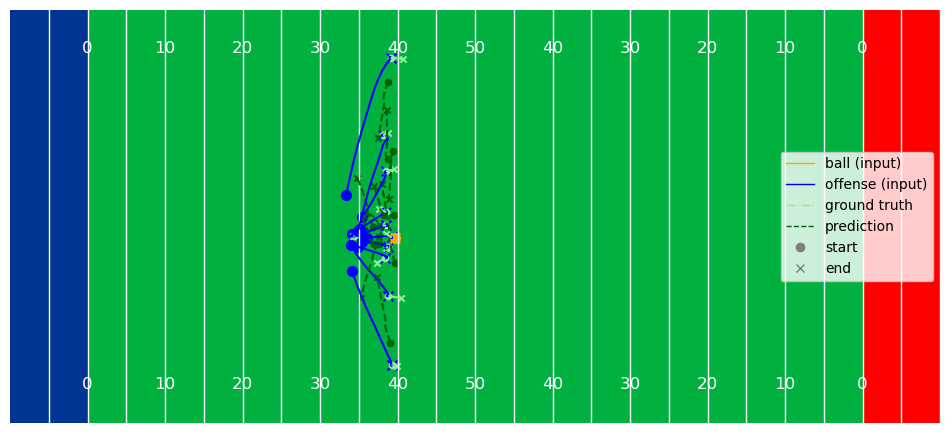

In [7]:
# Filter to test rows and pick one at random
N_STEPS = 10

row = (
    df
    .loc[df['split'] == "test", ['gameId', 'playId']]
    .sample(n=1) 
)

# Extract into Python variables
gameId = row['gameId'].iloc[0]
playId = row['playId'].iloc[0]

print(f"Selected gameId = {gameId}, playId = {playId}")

context_seq, gt_future = load_play(
    parquet_path="../../processed_data/model_input_2.parquet",
    game_id=gameId,
    play_id=playId,
    ctx_len=100,
    n_future=N_STEPS,
)

pred = predict_k_steps(model, context_seq[0], k=N_STEPS)

PLAYER_NUM= 10

print(context_seq.shape)
print(context_seq[0][0,PLAYER_NUM]*120)
print(gt_future.shape)
print(gt_future[0][0,PLAYER_NUM] *120)
print(pred.shape)
print(pred[0,10] *120)

_ = custom_visualizer.plot_trajectories(
        sequence=context_seq[0],
        ground_truth_seq=gt_future,
        pred_seq=pred,
        offense='all', defense=None, include_ball=True)

## Evalute on all test set

In [18]:
%%time

N_STEPS = 40

# Grab only test split ids
ids_in_test = game_indexer.loc[game_indexer['split'] == "test", ['gameId', 'playId']]

# Will hold an (n_plays, N_STEPS) array of L2 errors
all_errors = []

# Loop over every play in the test set
for gameId, playId in tqdm(ids_in_test.values, desc="Evaluating test plays"):
    # load context + ground truth future
    context_seq, gt_future = load_play(
        parquet_path="../../processed_data/model_input_2.parquet",
        game_id=gameId,
        play_id=playId,
        ctx_len=100,
        n_future=N_STEPS,
    )

    # Skip if sequence is empty
    if context_seq is None or gt_future is None:
        continue
    # Skip if sequence is all zeros
    if np.all(context_seq == 0) or np.all(gt_future == 0):
        continue
    # Skip if gt_future is less than N_STEPS
    if gt_future.shape[1] < N_STEPS:
        continue

    # Calculate length of the sequence to be predicted
    seq_len = gt_future.shape[1]  # (100, 46)
    
    # autoregressive prediction
    pred = predict_k_steps(model, context_seq[0], k=seq_len)  # (N_STEPS, 46)
    
    # ground-truth for those same steps
    gt = gt_future[0]                                       # (N_STEPS, 46)
    
    # per-frame Euclidean distance (add small eps for stability)
    dists = np.sqrt(np.sum((pred - gt)**2, axis=-1) + 1e-6)  # (N_STEPS,)
    
    all_errors.append(dists)

all_errors = np.stack(all_errors)  # shape = (n_plays, N_STEPS)

# mean error at each future step
mean_error_per_step = all_errors.mean(axis=0)  # (N_STEPS,)

# overall mean error (averaged across all plays & steps)
overall_mean_error = all_errors.mean()


print("Mean Euclidean error at each horizon step:")
for i, err in enumerate(mean_error_per_step, start=1):
    print(f"  step {i:2d}: {err:.4f}")

print(f"\nOverall mean Euclidean error (all plays & steps): {overall_mean_error:.4f}")
print(f"\nMultiplied by 120: {overall_mean_error * 120:.4f}")


Evaluating test plays: 100%|██████████| 3356/3356 [37:07<00:00,  1.51it/s] 

Mean Euclidean error at each horizon step:
  step  1: 0.1463
  step  2: 0.1798
  step  3: 0.2069
  step  4: 0.2336
  step  5: 0.2601
  step  6: 0.2859
  step  7: 0.3113
  step  8: 0.3361
  step  9: 0.3606
  step 10: 0.3849
  step 11: 0.4091
  step 12: 0.4333
  step 13: 0.4575
  step 14: 0.4817
  step 15: 0.5061
  step 16: 0.5306
  step 17: 0.5553
  step 18: 0.5802
  step 19: 0.6053
  step 20: 0.6307
  step 21: 0.6564
  step 22: 0.6824
  step 23: 0.7089
  step 24: 0.7359
  step 25: 0.7634
  step 26: 0.7914
  step 27: 0.8202
  step 28: 0.8498
  step 29: 0.8804
  step 30: 0.9121
  step 31: 0.9452
  step 32: 0.9803
  step 33: 1.0198
  step 34: 1.0659
  step 35: 1.1029
  step 36: 1.1566
  step 37: 1.1999
  step 38: 1.2411
  step 39: 1.2871
  step 40: 1.3245

Overall mean Euclidean error (all plays & steps): 0.6755

Multiplied by 120: 81.0587
CPU times: total: 2h 35min 26s
Wall time: 37min 7s
